# Qiskit handbook

Qiskit (Quantum Information Software Kit) - опенсорсный SDK  для работы с квантовыми компьютерами (КК) на уровне схем, импульсов и алгоритмов. Разработан в IBM и используется для запуска программ для КК как на локальных симуляторах, так и на реальных КК IBM.

## Установка библиотек

При запуске ноутбука в среде Google Colab после установки библиотек необходимо перезапустить сеанс (*Среда выполнения -> Перезапустить сеанс*)

Qiskit периодически обновляется, и туториалы в интернете быстро устаревают (синтаксис сильно меняется). Нужно учитывать версию библиотеки при работе

In [ ]:
!pip install qiskit==1.3.2
!pip install qiskit_ibm_runtime
!pip install qiskit_aer
!pip install qiskit_machine_learning
!pip install qiskit_dynamics
!pip install pylatexenc

## Базовые понятия

**Кубит** - квантовый бит, по своему значению находится в суперпозиции состояний 0 и 1, математически - двумерный комплексный вектор

**Гейт** - унитарная операция над одним или несколькими кубитами. Похожи на классические логические вентили. Математически, гейт - это умножение вектора-кубита на матрицу. Список доступных гейтов: [документация Qiskit с VPN](https://docs.quantum.ibm.com/api/qiskit/circuit_library#standard-gates), [без VPN, но тоже на английском](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-states/single-qubit-gates.ipynb)

**Квантовая схема** - действия (последовательность гейтов), которые должны быть выполнены за один запуск на QPU

**QPU** - квантовый процессор (по аналогии с CPU и GPU)

**ISA (Instruction Set Architecture)** - абстрактная модель того, какие операции доступны для тех или иных наборов аппаратных кубитов на одном конкретном QPU. Например, один QPU может разрешать операции *sqrt(X)* и *Rz* на всех одиночных аппаратных кубитах, а операции *CX* - только на определенных парах кубитов

**Измерение** - операция извлечения классического бита данных из состояния кубита. Необратимая операция, ломающая квантовую запутанность

**Транспиляция (transpilation)** - процесс преобразования схемы под топологию конкретного QPU, разложение более сложных гейтов в набор простых, доступных на физическом устройстве. Подробнее в [документации](https://docs.quantum.ibm.com/api/qiskit/transpiler)

**IBM Quantum Composer** - визуальный конструктор квантовых схем. Цветные блоки - гейты - перетаскиваются на линии - кубиты. Позволяет работать со схемами без кода

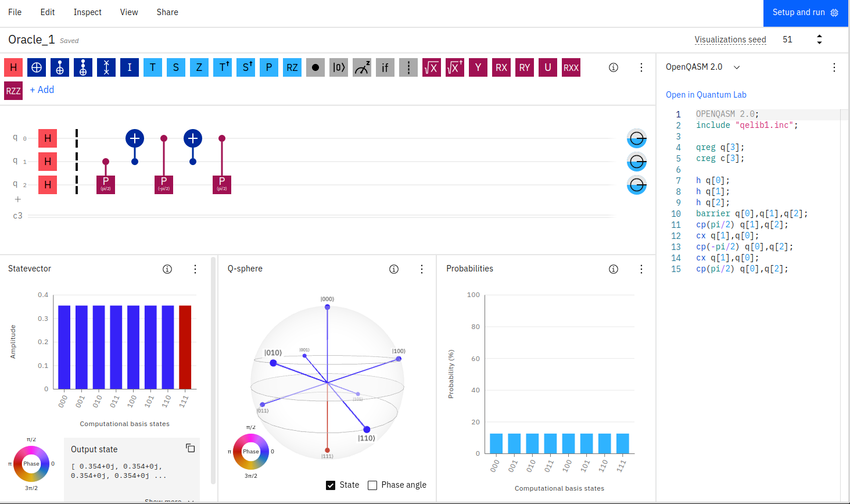

Создадим простую схему и запустим ее на симуляторе:

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector


# создадим квантовую схему из двух кубитов
circuit = QuantumCircuit(2,2)

Гейты добавляются на схему как методы объекта схемы:

In [ ]:
# добавляем гейт Адамара - он создает суперпозицию
circuit.h(0)
# состояния кубитов: 00 -> 10

# добавляем гейт CX - он инвертирует состояние первого кубита, если нулевой = 1
circuit.cx(0, 1)
# состояния кубитов: 10 -> 11

In [ ]:
# проведем измерения
circuit.measure([0, 1], [0, 1])
circuit.save_statevector()

In [ ]:
# можно отрисовать получившуюся схему символами
circuit.draw()

┌───┐     ┌─┐    statevector 
q_0: ┤ H ├──■──┤M├─────────░──────
     └───┘┌─┴─┐└╥┘┌─┐      ░      
q_1: ─────┤ X ├─╫─┤M├──────░──────
          └───┘ ║ └╥┘      ░      
c: 2/═══════════╩══╩══════════════
                0  1

In [ ]:
# импортируем симулятор КК
from qiskit_aer import AerSimulator


# транспайлим под симулятор КК
simulator = AerSimulator()
circuit = transpile(circuit, simulator)

При запуске схемы происходит 1024 измерения выходных состояний двух кубитов. Видим, что результаты 00 и 11 близки по количеству, так как схема выдает состояния 00 и 11 с равной вероятностью. Подсчеты немного разные, так как квантовые компьютеры чувствительны к помехам - отсюда случайные ошибки

[Bell-state](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%91%D0%B5%D0%BB%D0%BB%D0%B0) - состояния запутанных двух кубитов:

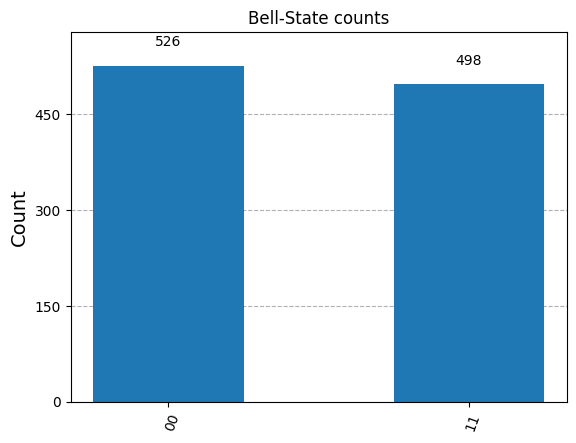

In [ ]:
# запускаем и получаем результаты Bell-state
result = simulator.run(circuit).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

Также можно представить результирующие состояния кубитов на [сфере Блоха](https://ru.wikipedia.org/wiki/%D0%A1%D1%84%D0%B5%D1%80%D0%B0_%D0%91%D0%BB%D0%BE%D1%85%D0%B0):

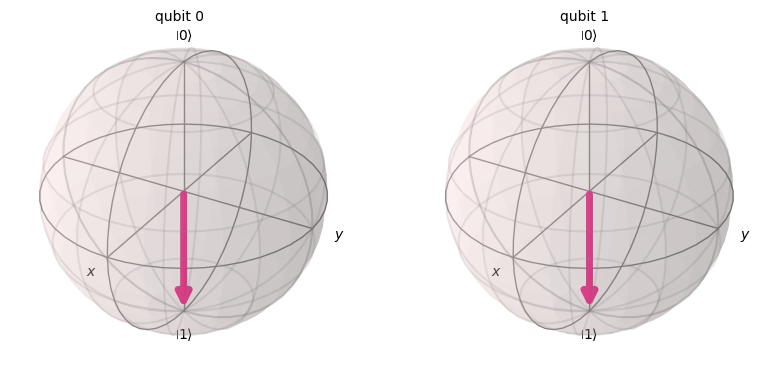

In [ ]:
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

Для другой схемы результаты будут другими:

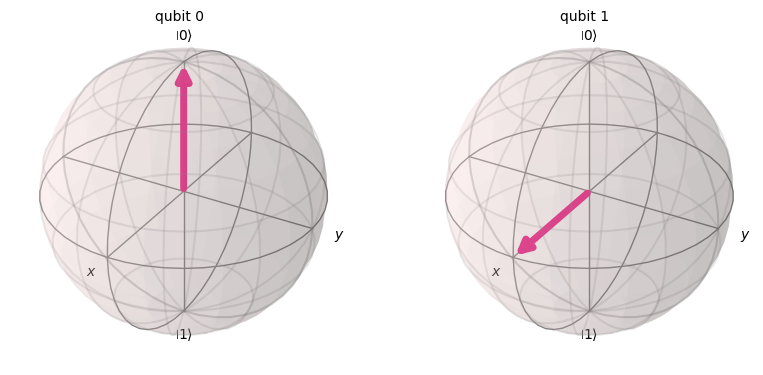

In [ ]:
circuit = QuantumCircuit(2,2)
circuit.h(1)
circuit.p(pi/4, 0)
circuit.save_statevector()

simulator = AerSimulator()
circuit = transpile(circuit, simulator)

result = simulator.run(circuit).result()

statevector = result.get_statevector()
plot_bloch_multivector(statevector)

## Подключаемся к процессору IBM

IBM дает возможность запускать схемы на своих QPU. Для этого необходимо создать аккаунт (IBMid) на сайте https://quantum.ibm.com/account и создать ключ API:

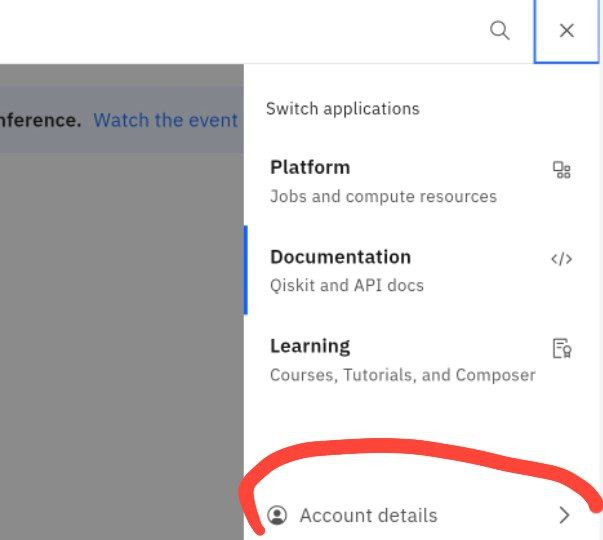

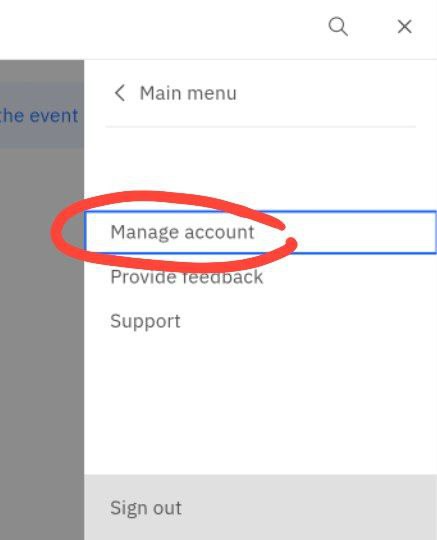

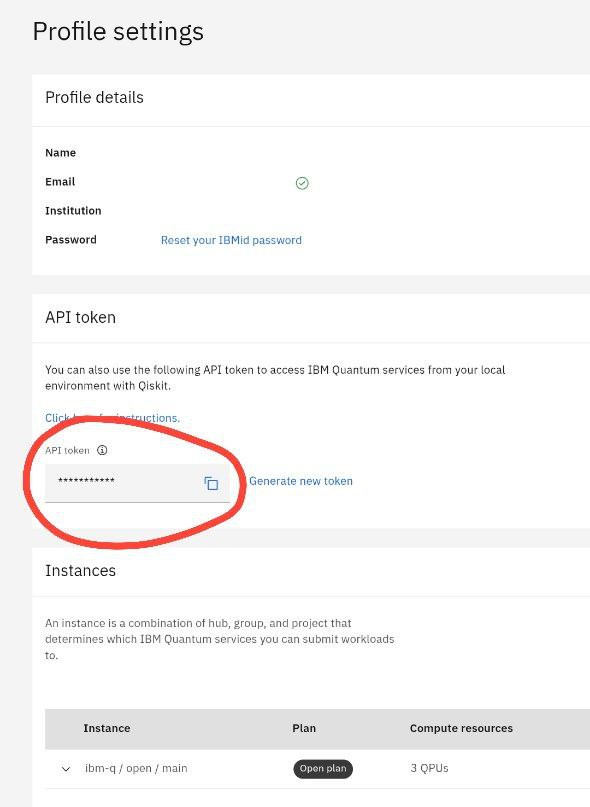

In [ ]:
token = 'MY_IBM_QUANTUM_TOKEN'

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# сохраняем настройки аккаунта, чтобы использовать его далее
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum"
)

In [ ]:
# подгружаем сохраненный раньше аккаунт (токен)
service = QiskitRuntimeService()

# можно посмотреть список доступных QPU
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

Для работы с реальным процессором нужно дождаться очереди на выполнение. Программа ниже была в очереди 25 минут:

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler
from math import pi


circuit = QuantumCircuit(2)
circuit.h(0)
circuit.p(pi/4, 0)
circuit.measure_all()

# выбираем наименее загруженный QPU, не являющийся симулятором
backend = service.least_busy(operational=True, simulator=False)

circuit = transpile(circuit, backend)

sampler = Sampler(backend)
job = sampler.run([circuit])
print(f"job id: {job.job_id()}")
result = job.result()
result

job id: cybpq1mcw2k0008kgnm0
PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2025-01-27 11:44:40', stop='2025-01-27 11:45:14', size=4096>)])}, 'version': 2})


In [ ]:
data_pub = result[0].data

# Получаем измерения для классического регистра (там, где хранятся полученные результаты)
bitstrings = data_pub.meas.get_bitstrings()
print(f"Количество измерений: {len(bitstrings)}")

# Получаем количество каждого полученного варианта результата работы схемы
counts = data_pub.meas.get_counts()
print(f"Подсчеты результатов: {counts}")

Количество измерений: 4096
Подсчеты результатов: {'01': 2048, '00': 2047, '10': 1}


## Последовательность создания квантовой программы

Этапы написания квантовой программы с Qiskit:
1. Перевести задачу в понятный формат для квантовых схем
2. Оптимизировать схему
3. Запустить схему
4. Проанализировать результаты

### 1. Создание квантовой схемы

В квантовой программе **квантовые схемы** - это нативный формат представления квантовых инструкций, а **операторы** - объекты, состояние которых мы будем измерять. При создании схемы обычно создается объект QuantumCircuit, в который затем последовательно добавляются инструкции.

Ячейка ниже создает схему, возпроизводяющую [состояние Белла](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%91%D0%B5%D0%BB%D0%BB%D0%B0) - состояние с полной запутанностью двух кубитов

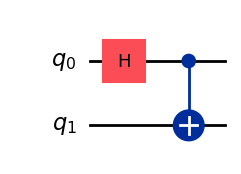

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Создаем новую схему из двух кубитов
qc = QuantumCircuit(2)

# Добавляем оператор Адамара на нулевой кубит
qc.h(0)

# Добавляем управляемый X-гейт на первый кубит, с управлением через нулевой
qc.cx(0, 1)

# Отрисовываем схему через Matplotlib
# Если убрать аргумент 'mpl' - будет отрисовка текстовыми символами
qc.draw("mpl")

При создании квантовых схем надо учитывать, какой тип данных будет возвращен после выполнения. В Qiskit есть два вида возврата результатов: распределение вероятностей для измеряемых кубитов и матожидание наблюдаемой величины.

В этой схеме измеряются матожидания, через модуль qiskit.quantum_info. В ячейке ниже создаем шесть двухкубитных операторов Паули: *IZ, IX, ZI, XI, ZZ* и *XX*.

In [2]:
# Задаем шесть измеряемых величин

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

### 2. Оптимизация схемы

При выполнении схем на устройстве важно оптимизировать набор инструкций, которые содержит схема. Это гарантирует получение лучших результатов за счет уменьшения влияния ошибок и шумов. Кроме того, инструкции схемы должны соответствовать архитектуре набора инструкций (ISA) бэкенда и учитывать базисные гейты устройства (те, которые есть на нем физически) и связность кубитов

In [3]:
# для работы понадобится API-токен IBMid
token = 'MY_IBM_QUANTUM_TOKEN'

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# сохраняем аккаунт с токеном
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum"
)

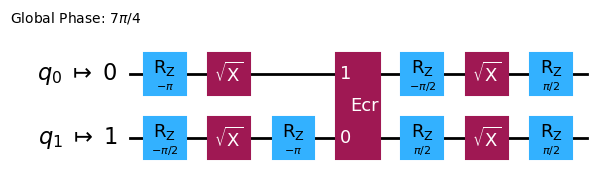

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService()
# выбираем наименее загруженный бэкенд
backend = service.least_busy()

# конвертируем схему для соответствия архитектуре (ISA) квантового процессора
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

### 3. Запуск схемы

Квантовые компьютеры могут давать случайные результаты, поэтому обычно нужно получить множество результатов, запуская схему много раз. Это приблизит практические значения к теоретическим. Значение наблюдаемой величины можно оценить с помощью класса Estimator. Estimator - это один из двух [примитивов](https://docs.quantum.ibm.com/guides/primitives), второй - Sampler, который используется для получения данных из квантового компьютера. Эти объекты отвечают за выбор схем, измеряемых величин и параметров, используя [примитивный унифицированный блок](https://docs.quantum.ibm.com/guides/primitives#sampler) (PUB).

In [6]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# Один PUB c одной схемой на запуск, у схемы несколько измеряемых величин
job = estimator.run([(isa_circuit, mapped_observables)])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cyc90ktrta1g0087t5r0


In [7]:
# результат запуска job - для одного PUB один внутренний результат
job_result = job.result()

# результат одного запуска с 6 измеряемыми величинами
pub_result = job.result()[0]

In [9]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

### 4. Результаты

Значения измеряемых величин - матожидание и стандартное отклонение:

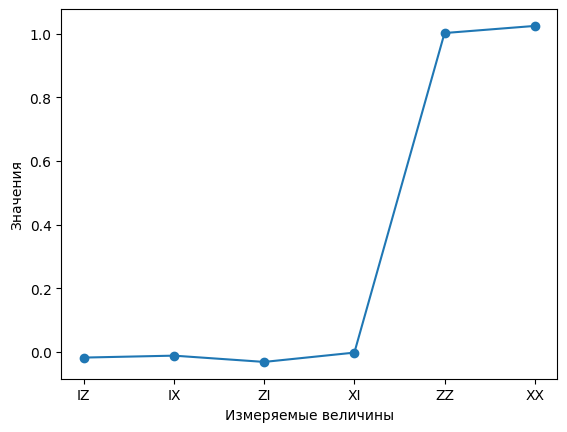

In [10]:
from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("Измеряемые величины")
plt.ylabel("Значения")
plt.show()

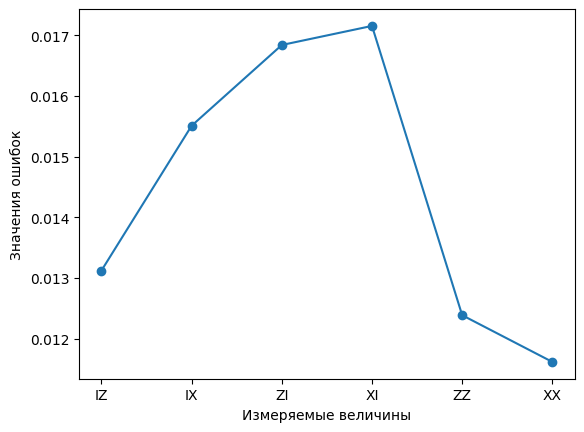

In [11]:
plt.plot(observables_labels, errors, "-o")
plt.xlabel("Измеряемые величины")
plt.ylabel("Значения ошибок")
plt.show()

## Алгоритм Дойча — Йожи (Deutsch–Jozsa)

Алгоритм Дойча — Йожи - первый алгоритм, в котором квантовый компьютер превосходил классический.

Кратко:

- У нас есть неизвестная булева функция, которая принимает на вход строки битов и возвращает либо 0, либо 1
- Нужно определить, будет ли выход постоянным (все 0 или все 1), или сбалансированным, т.е. с четным количеством 0 и 1
- На классическом компьютере, если есть строка из двух битов, потребуется как минимум 2 запроса, чтобы понять, является ли она постоянной или сбалансированной. С каждым новым битом задача будет занимать экспоненциально больше времени. КК может определить результат за 1 запрос, независимо от длины битовой строки


Эта задача далека от практических, но на ней можно увидеть сильные стороны КК

In [ ]:
# black box функции, выдающие сбалансированные результаты или константу
def balanced_black_box(c):
  c.cx(0, 2)
  c.cx(1, 2)
  return c

def constant_black_box(c):
  return c

Подставляем в схему одну из функций:

In [ ]:
c = QuantumCircuit(3,2)
c.x(2)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.barrier()
c = balanced_black_box(c)
# c = constant_black_box(c)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.measure([0,1], [0,1])
c.draw()

░ ┌───┐ ░            ░ ┌───┐┌─┐   
q_0: ──────░─┤ H ├─░───■────────░─┤ H ├┤M├───
           ░ ├───┤ ░   │        ░ ├───┤└╥┘┌─┐
q_1: ──────░─┤ H ├─░───┼────■───░─┤ H ├─╫─┤M├
     ┌───┐ ░ ├───┤ ░ ┌─┴─┐┌─┴─┐ ░ ├───┤ ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░─┤ X ├┤ X ├─░─┤ H ├─╫──╫─
     └───┘ ░ └───┘ ░ └───┘└───┘ ░ └───┘ ║  ║ 
c: 2/═══════════════════════════════════╩══╩═
                                        0  1

Результат для balanced_black_box:

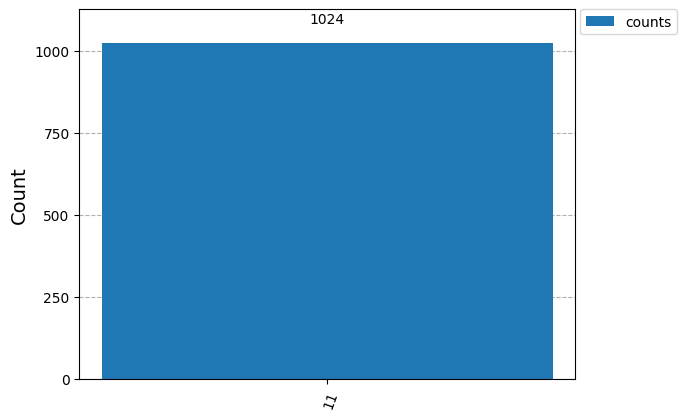

In [ ]:
c = transpile(c, simulator)
result = simulator.run(c).result()

new_counts = result.get_counts()
plot_histogram([new_counts], legend=['counts'])

Результат для constant_black_box:

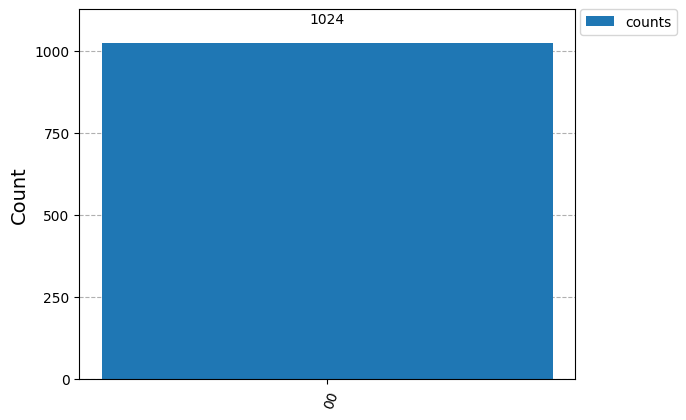

In [ ]:
c = transpile(c, simulator)
result = simulator.run(c).result()

new_counts = result.get_counts()
plot_histogram([new_counts], legend=['counts'])

Как видно по результатам выше, в случае с сбалансированным выходом функции в результате измерений всегда получаем 11. Для константной функции - 00.

Классическому компьютеру потребовалось бы запустить функцию два раза, чтобы определить результат, а квантовый позволяет классифицировать функцию за 1 запуск

## QASM

QASM - простой текстовый язык, с элементами языков Си и ассемблера. Он используется для описания или задания квантовых схем. QASM позволяет конвертировать схемы в универсальный формат, с которым работает разное ПО

Экспорт схемы в QASM:

In [ ]:
from qiskit import QuantumCircuit, qasm2


circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure([0, 1], [0, 1])

# экспортируем в строку
program = qasm2.dumps(circuit)

# экспортируем в файл
qasm2.dump(circuit, "my_file.qasm")

In [ ]:
print(program)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


Чтение схемы из QASM:

In [ ]:
import qiskit.qasm2

circuit = qiskit.qasm2.loads(program, include_path=('.',), custom_instructions=(), custom_classical=(), strict=False)
circuit.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

## Работа с импульсами

В Qiskit можно взаимодействовать с кубитами на уровне импульсов. За это отвечает подмодуль pulse.

P.S. Также есть обширная область по работе с калибровками параметров кубитов. Это необходимо для борьбы с шумами и ошибками и включает в себя много действий по обработке сырых данных с QPU

Примеры кода для работы с импульсами: https://qiskit-community.github.io/qiskit-dynamics/tutorials/index.html

Qiskit Pulse позволяет задавать зависимость от времени в квантовых системах в виде расписания импульсов (pulse schedule), построенного из последовательностей инструкций, включая создание импульсов разной формы.

Для примера мы создадим расписание импульсов для простого кубита. Сначала применим к кубиту последовательности импульсов, работающих как гейт SX, добавив затем сдвиг по фазе, превратив SX в SY.

<ipython-input-1-95dc2f99cf04>:21: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="sx-sy schedule") as sxp:
<ipython-input-1-95dc2f99cf04>:22: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
<ipython-input-1-95dc2f99cf04>:22: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and wil

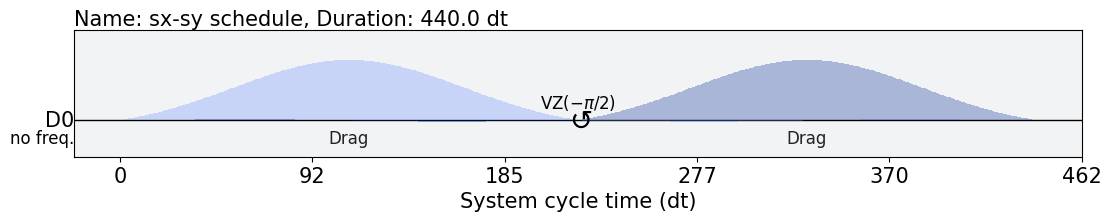

In [1]:
import numpy as np
import qiskit.pulse as pulse

# Strength of the Rabi-rate in GHz.
# Мощность воздействия нашего сигнала, ГГц
r = 0.1

# Частота кубита, ГГц
w = 5.

# Время обновления бэкенда, нс
dt = 1 / 4.5

# Задаем гауссову огибающую функцию, чтобы приблизительно смоделировать SX-гейт
amp = 1. / 1.75
sig = 0.6985/r/amp
T = 4*sig
duration = int(T / dt)
beta = 2.0

with pulse.build(name="sx-sy schedule") as sxp:
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))

sxp.draw()

Сконвертируем огибающую в сигнал (обрежем колебания огибающей функцией):

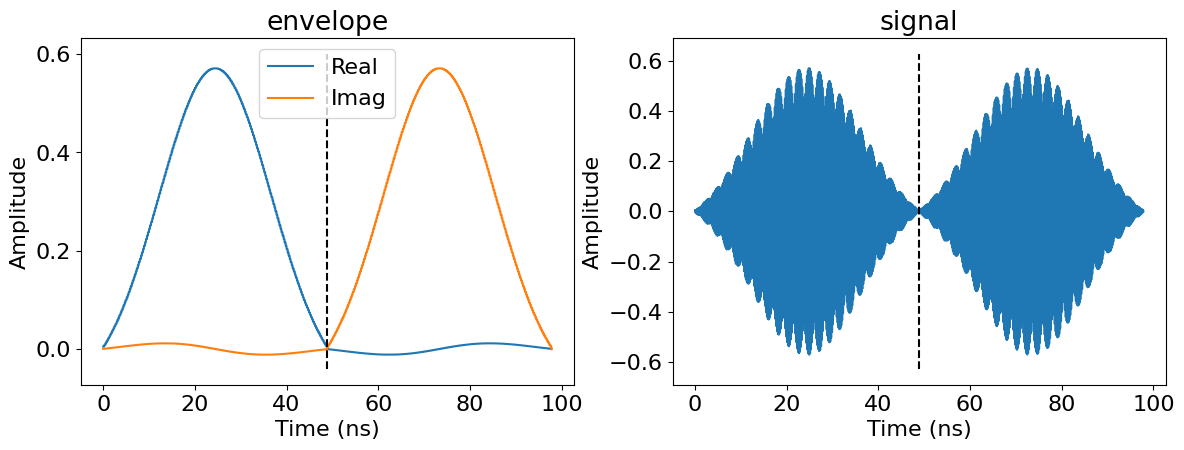

In [4]:
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals

plt.rcParams["font.size"] = 16

converter = InstructionToSignals(dt, carriers={"d0": w})

signals = converter.get_signals(sxp)
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

Создаем солвер и передаем ему параметры для симуляции последовательности импульсов:

In [6]:
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver

X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

Запускаем симуляцию:

In [7]:
from qiskit.quantum_info.states import Statevector

# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

%time sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=sxp, atol=1e-8, rtol=1e-8)

CPU times: user 27 s, sys: 87.2 ms, total: 27.1 s
Wall time: 31.2 s


In [12]:
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Вероятность |0>")
    plt.plot(sol.t, pop1, lw=3, label="Вероятность |1>")
    plt.xlabel("Время (нс)")
    plt.ylabel("Вероятность")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

График показывает вероятности получить кубит в одном из его состояний при измерении. Вертикальная пунктирная линия показывает время виртуального поворота по оси Z, который был вызван командой shift_phase в расписании импульсов.

Первый импульс переводит кубит в собственное состояние (eigenstate) оператора Y. Поэтому второй импульс, который вращает вокруг оси Y, почти не влияет на состояние кубита

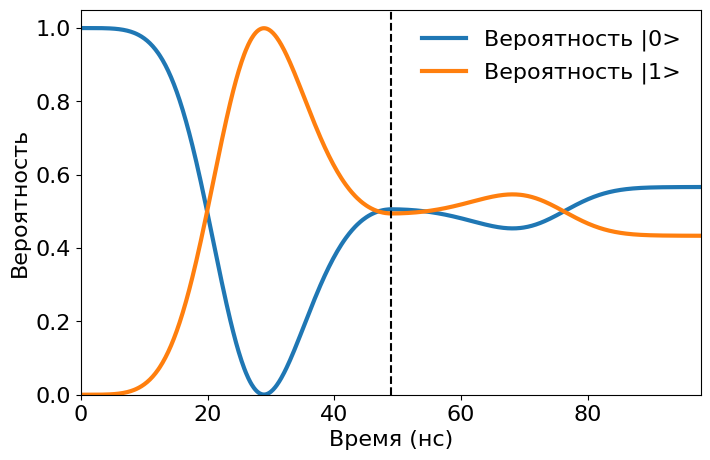

In [13]:
plot_populations(sol)

## Quantum ML

Qiskit также позволяет создавать модели машинного обучения. Обучим простую модель [VQR](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQR.html) (вариативный квантовый регрессор)

Еще больше применений quantum ML: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/index.html

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

Задаем данные для обучения - синусоида с шумом:

In [ ]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

Создаем estimator - StatevectorEstimator - для симуляции запуска. callback_graph - функция для обновления графика в процессе обучения

In [ ]:
estimator = Estimator()
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Квантовые схемы - карта признаков feature_map (с входными параметрами) и ansatz (с обучаемыми весами)

In [ ]:
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

In [ ]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
    estimator=estimator,
)

Процесс обучения:

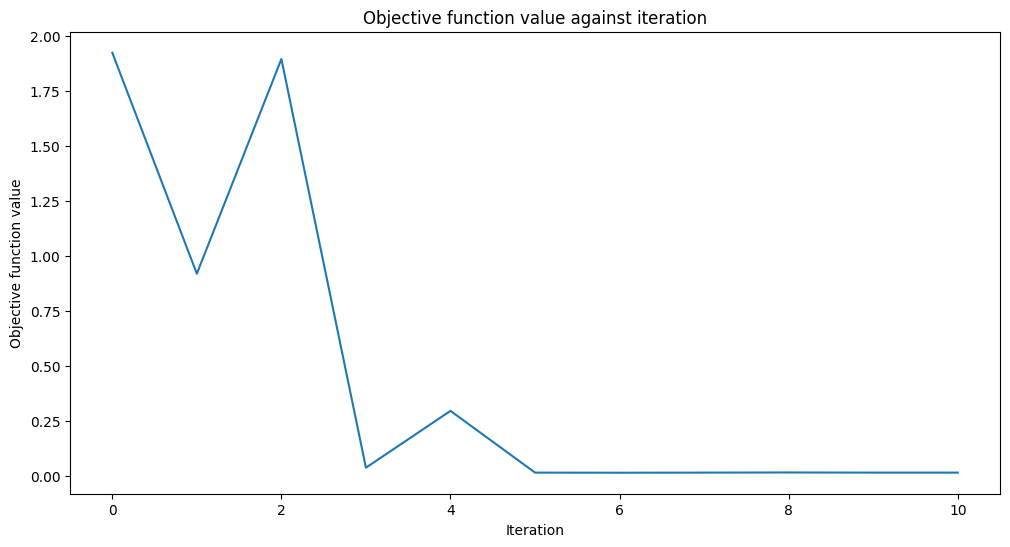

0.9735269180142593

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

Результат - зеленый график с предсказаниями подстроился под исходные данные

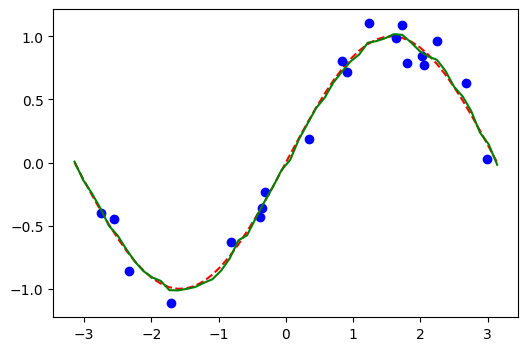

In [ ]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()